In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../data/patches-filtered.csv', sep=",", index_col=['id', 'name'])
data.head(3)

,,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
id,name,,,,,,
5299,plexi*dly*,74.0,102.0,55.0,107.0,107.0,107.0
5300,HB*Boston3,31.0,102.0,33.0,107.0,107.0,107.0
5301,_Clean****,24.0,31.0,28.0,107.0,107.0,107.0


In [3]:
print('Nones by position')
[data[data[f'plugin{i}'] == 107][f'plugin{i}'].count() for i in range(1, 7)]

Nones by position


[0, 0, 0, 376, 696, 1059]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a22ab0fd0>,
      dtype=object)

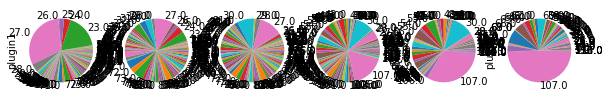

In [4]:
dataframe = pd.DataFrame(data={
    f'plugin{i}': data[f'plugin{i}'].value_counts()
    for i in range(1, 7)
}).fillna(0)

dataframe.plot.pie(subplots=True, legend=False, figsize=(10, 10))

### Total of plugins

In [5]:
plugins = [data[column] for column in data.columns]

plugins_use = pd.concat(plugins).value_counts()
plugins_use.name = 'total'
plugins_use.head()

107.0    2131
27.0     1307
30.0      735
23.0      508
71.0      355
Name: total, dtype: int64

In [6]:
plugins_categories = pd.read_csv('../data/plugins_categories_simplified.csv', sep=",", index_col=['id'])
plugins_categories.groupby('category').count()

,name
category,
Amp,28
Combination Fx,7
Delay,12
Dynamics,7
Filter_EQ,10
Modulation,22
None,1
Pedal Fx,4
Reverb,8


In [7]:
plugins_categories.join(plugins_use.to_frame()).head()

,name,category,total
id,,,
23,Comp,Dynamics,508.0
24,RackComp,Dynamics,206.0
25,M Comp,Dynamics,107.0
26,SlowATTCK,Dynamics,51.0
27,ZNR,Dynamics,1307.0


In [8]:
plugins_categories.join(plugins_use.to_frame()).groupby('category').sum()

,total
category,
Amp,1678.0
Combination Fx,225.0
Delay,1069.0
Dynamics,2451.0
Filter_EQ,1140.0
Modulation,1168.0
None,2131.0
Pedal Fx,248.0
Reverb,1320.0


# Use of plugins

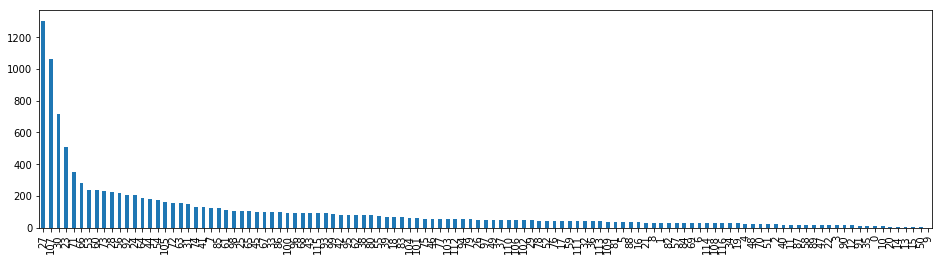

In [9]:
plugins = [(i, (data == (i, ) * 6).any(axis=1).sum()) for i in range(0, 117)]

plugins_frenquencies = pd.DataFrame(plugins, columns=['id', 'total']).sort_values('total', ascending=False)

plugins_frenquencies['total'].plot.bar(figsize=(16, 4))

In [10]:
from functools import reduce

plugins_use = []

for i, plugin in plugins_frenquencies.sort_values('total', ascending=True).iterrows():
    plugins_use.append((i, data == ((i, ) * 6)))

use = []
last = None
for i, plugin_use in plugins_use:
    if last is None:
        last = plugin_use.copy()
    
    last |= plugin_use
    use.append((i, last.any(axis=1).sum()))

use = pd.DataFrame(use, columns=['id', 'cumulative_use'])
use['cdf'] = use['cumulative_use'] / data.shape[0]

use.index = use['id']

use.head()

,id,cumulative_use,cdf
id,,,
9,9,0,0.000000
50,50,4,0.001851
15,15,9,0.004165
13,13,14,0.006478
14,14,19,0.008792


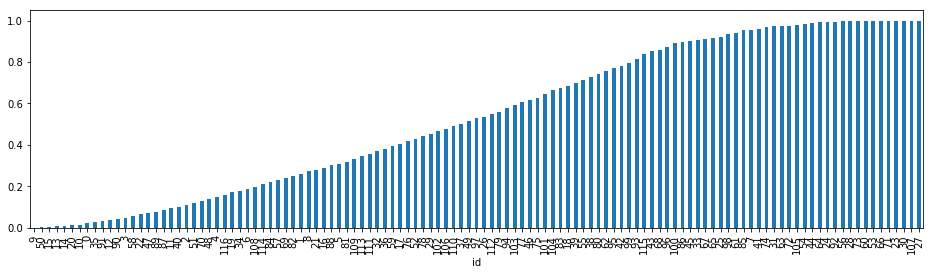

In [11]:
use['cdf'].plot.bar(figsize=(16, 4))

In [12]:
# Remove 50%
total = len(plugins_use)
remove = total/2
use = plugins_use[0][-1].copy()

for i, plugin_use in plugins_use:
    if total < remove:
        break

    use |= plugin_use
    total -= 1

print("Total of patches:", use.any(axis=1).sum())

Total of patches: 1145


In [13]:
filtered_data = data[use.any(axis=1) == False]
remain_plugins = np.unique(filtered_data.values)

for new_id, old_id in enumerate(remain_plugins):
    filtered_data = filtered_data.replace(old_id, new_id)

print('Total of plugins', len(remain_plugins))
remain_plugins_map = pd.DataFrame(remain_plugins)
remain_plugins_map = remain_plugins_map.reset_index()
remain_plugins_map.columns = ['new_id', 'original_id']

remain_plugins_map.head(3)

Total of plugins 58


,new_id,original_id
0,0,7.0
1,1,18.0
2,2,23.0


In [14]:
filtered_data.head()

,,plugin1,plugin2,plugin3,plugin4,plugin5,plugin6
id,name,,,,,,
5301,_Clean****,3.0,9.0,7.0,55.0,55.0,55.0
5350,AC*DC*****,7.0,52.0,24.0,55.0,55.0,55.0
5358,DearPruden,47.0,14.0,21.0,55.0,55.0,55.0
5359,PaganBaby*,50.0,27.0,30.0,55.0,55.0,55.0
5360,WalkOnWate,47.0,27.0,30.0,55.0,55.0,55.0


In [15]:
filtered_data.to_csv('../data/patches-filtered-filtered.csv')

In [16]:
plugins_categories = pd.read_csv(f'../data/plugins_categories_simplified.csv', sep=",", index_col=['id'])

copy = remain_plugins_map.copy()
copy.index = copy['original_id']

#remain_plugins_map#.to_csv('../data/patches-filtered-filtered.csv')
plugins_categories #.iloc[remain_plugins_map[0].values]
#remain_plugins_map#[0].values
plugins_categories_small = plugins_categories.join(copy)
plugins_categories_small = plugins_categories_small[plugins_categories_small['new_id'].isna() == False]
plugins_categories_small.index = plugins_categories_small['new_id']
plugins_categories_small.index.name = 'id'
del plugins_categories_small['new_id']
del plugins_categories_small['original_id']
plugins_categories_small.index = plugins_categories_small.index.astype(np.int32)

plugins_categories_small.to_csv('../data/plugins_categories_simplified_simplified.csv')
plugins_categories_small.head(5)

,name,category
id,,
2,Comp,Dynamics
3,RackComp,Dynamics
4,M Comp,Dynamics
5,SlowATTCK,Dynamics
6,ZNR,Dynamics
